In [1]:
import os
import glob
import cv2
import time
import random
import torch
import geffnet
import argparse
import pandas as pd
import numpy as np
import torch.nn as nn
import pretrainedmodels
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.cuda import amp
from sklearn.model_selection import StratifiedKFold, GroupKFold
from torch.utils.data import TensorDataset, DataLoader,Dataset, RandomSampler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import label_ranking_average_precision_score

SEED = 13
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
!pwd

/home/pka/kaggle/Rainforest/notebook_private


In [3]:
# PATH_IMG = '../input/make-img-sr32power2mel384-ch-f0-9-f1-1-power-to-db/train_img.zip'
# PATH_IMG = '../input/experement-make-img-sr32power2mel384-ff111-pow/train_img.zip'
# PATH_IMG = '/home/pka/kaggle/Rainforest/notebook_private/exp_train_img32.zip'
PATH_IMG = '/home/pka/kaggle/Rainforest/notebook_private/train_img_260_default.zip'#default_train_img32.zip'
PATH_MODEL = '/home/pka/kaggle/Rainforest/notebook_private/model_optuna/'

In [4]:
# !pip install albumentations --upgrade albumentations

In [5]:
!pip3 install pretrainedmodels

In [6]:
!pip3 install geffnet

In [7]:
!pip3 install optuna --upgrade optuna

Requirement already up-to-date: optuna in /home/pka/.local/lib/python3.8/site-packages (2.5.0)


In [8]:
import optuna
# import albumentations as A

In [9]:
df = pd.read_csv('/home/pka/kaggle/Rainforest/input/train_tp.csv')

df['dif_f'] = df.f_max - df.f_min
df['dif_f'] = df['dif_f'].astype(int)
df['bins'] = pd.cut(df.dif_f, 15, labels=False)

df['file_name'] = 'file_name'
data = np.load(PATH_IMG)
for i in data.files[1:]:
    recording_id, species_id, idx = i.split('.')[0], i.split('.')[1], i.split('.')[2]
    if (df.loc[int(idx), 'recording_id'] == recording_id.split('/')[1] and df.loc[int(idx), 'species_id'] == int(species_id)):
        df.loc[int(idx),'file_name'] = i
    else:
        print(idx, recording_id, i)

In [10]:
"""
folds to dataset 384
"""

# rec = []
# tr_idx = []
# vl_idx = []
# data = np.load(PATH_IMG)
# # for name in data.files[1:]:
# #     rec_id = name.split('.')[0].split('/')[1]    
# #     rec.append(rec_id)   
    

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# for f, (tr, vl) in enumerate(skf.split(df, df.bins.values)):
#     print(len(tr), len(vl))
#     tr_idx.append(tr)
#     vl_idx.append(vl) 
    
# a = np.take(df.file_name.values, tr_idx[0])

In [11]:
"""
folds to dataset 260
"""

rec = []
tr_idx = []
vl_idx = []
data = np.load(PATH_IMG)
# for name in data.files[1:]:
#     rec_id = name.split('.')[0].split('/')[1]    
#     rec.append(rec_id)   
    

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
for f, (tr, vl) in enumerate(skf.split(data.files[1:], df.bins.values)):
    print(len(tr), len(vl))
    tr_idx.append(tr)
    vl_idx.append(vl) 
    
a = np.take(data.files[1:], tr_idx[0])

972 244
973 243
973 243
973 243
973 243


In [12]:
def rand_window(data: np.array)->np.array:
    """
    we cut data 384.563 = 10 sec by random start and all time len ~6sec 384*384
    
    
    test data shape (384, 376)
    """
    
    current_len = 563 # ~ 10 sec
    cut_len = 376 # ~ 6 sec   
    start = np.random.randint(0, current_len - cut_len)
    len_img = (start + cut_len) - start
    assert len_img == cut_len, f'error len {start}, {start + cut_len}'
    return data[:, start: start + cut_len]  

def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V
    
    
class RFDataset(Dataset):

    def __init__(self, data, transform = None):        
        # self.size = size     
        self.transform = transform
        self.zipdata = np.load(PATH_IMG)
        self.data = data # list name npy,
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        name = self.data[index] 
        img = self.zipdata[name] 
#         img_ori = self.zipdata[name]  
#         img = rand_window(img_ori)
        sci_id = name.split('.')[1]
        target = np.zeros(24)
        target[int(sci_id)] = 1
        img = mono_to_color(img)       
        # if self.size is not None:
        #     img = cv2.resize(img, (224, self.size)) 

        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']  
            
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)        
             
        return torch.tensor(img).float(),torch.tensor(target.astype(np.float16)).float() #check

torch.Size([3, 260, 563]) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


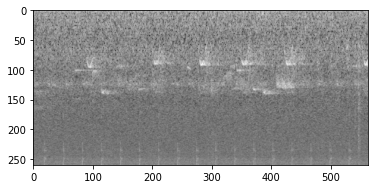

In [13]:
# transform = A.Compose([
#                        A.RandomBrightness(limit=0.2, p=0.75),
#                        A.RandomContrast(limit=0.2, p=0.75),
#                        A.MotionBlur(blur_limit=5),
#                        A.MedianBlur(blur_limit=5),
#                        A.GaussianBlur(blur_limit=5),
#                        A.GaussNoise(var_limit=(5.0, 30.0)),
#                        A.OpticalDistortion(distort_limit=1.0),
#                        A.GridDistortion(num_steps=5, distort_limit=1.),
#                        A.ElasticTransform(alpha=3),
#                        A.CLAHE(clip_limit=4.0, p=0.7),
#                        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#                        ])

d = RFDataset(a)
img, target = d[4]
print(img.shape, target)
plt.imshow(np.transpose(img, (1,2,0)))

In [14]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)
    
swish_layer = Swish_module()

# model for 384
# class EffB3(nn.Module):

#   def __init__(self):
#     super(EffB3, self).__init__()
#     self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
#     self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
# #     self.model.global_pool  = nn.AdaptiveMaxPool2d((1,1))
#     in_ch = self.model.classifier.in_features #1536
#     self.myfc = nn.Sequential(
#         nn.Dropout(0.29),
#         nn.Linear(in_ch, 1307),
#         nn.BatchNorm1d(1307),
#         nn.ReLU(),
# #         Swish_module(),
#         nn.Dropout(0.2),
#         nn.Linear(1307, 1307),
#         nn.BatchNorm1d(1307),
#         nn.ReLU(),
# #         Swish_module(),
#         nn.Dropout(0.2),         
#         nn.Linear(1307, 24)
#     )   
    
#     self.model.classifier = nn.Identity()   
      
#   def extract(self, x):        
#     x = self.model(x)        
#     return x
      
#   def forward(self, x):    
#     if len(torch.squeeze(x).shape) == 4:
#         x = torch.squeeze(x)
#     else:
#         x
#     bs, _, _, _ = x.shape    
#     x = self.extract(x)     
#     # x = x.view(bs, -1)   
#     x = self.myfc(x)
#     return x 

# model for 260
class EffB3(nn.Module):

  def __init__(self):
    super(EffB3, self).__init__()
    self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
    self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
#     self.model.global_pool  = nn.AdaptiveMaxPool2d((1,1))
    in_ch = self.model.classifier.in_features #1536
    self.myfc = nn.Sequential(
        nn.Dropout(0.17418),
        nn.Linear(in_ch, 785),
        nn.BatchNorm1d(785),
#         nn.ReLU(),
        Swish_module(),
        nn.Dropout(0.12), 
        
        nn.Linear(785, 1038),
        nn.BatchNorm1d(1038),
#         nn.ReLU(),
        Swish_module(),
        nn.Dropout(0.3763722),       
        nn.Linear(1038, 24)
    )   
    
    self.model.classifier = nn.Identity()   
      
  def extract(self, x):        
    x = self.model(x)        
    return x
      
  def forward(self, x):    
    if len(torch.squeeze(x).shape) == 4:
        x = torch.squeeze(x)
    else:
        x
    bs, _, _, _ = x.shape    
    x = self.extract(x)     
    # x = x.view(bs, -1)   
    x = self.myfc(x)
    return x

In [15]:
# !pip install torchsummary

In [16]:
# from torchsummary import summary
# summary(EffB3(ntarget = 24, nlayer = 1, h_size= 1024, dropout=0.5, activate_func='ReLU'), (3, 128, 550))

In [17]:
# m = nn.AdaptiveAvgPool2d((1,1))
# input = torch.randn(1, 2, 128, 128)
# m(input).shape

In [18]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def  train(model, loader, loss_f, optimizer, scaler):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    train_target = []
    train_prob = []
    for (img, target) in bar:
        optimizer.zero_grad()
        if scaler:
            # Runs the forward pass with autocasting.
            with amp.autocast():
                img, target = img.to(device), target.to(device)
                y_ = model(img)
                pred = loss_f(y_, target)
            scaler.scale(pred).backward()
            scaler.step(optimizer)
            scaler.update()   
        else:
            img, target = img.to(device), target.to(device)
            y_ = model(img)
            pred = loss_f(y_, target)
            pred.backward()
            optimizer.step()
        
        train_loss.append(pred.detach().cpu().numpy())
        prob = nn.Sigmoid()(y_)        
        train_prob.append(prob.detach().cpu())
        train_target.append(target.detach().cpu())            
    
    probs =  torch.cat(train_prob).numpy()
    target = torch.cat(train_target).numpy()   
#     auc = roc_auc_score(target, probs)
    auc =0
    return train_loss, auc


def val_train(model, loader, loss_f):
    val_loss = []
    target_temp = []
    probs = [] 
    val_corr = []
    model.eval()
    with torch.no_grad():
        bar = tqdm(loader)
        for (img, target) in bar:
            img, target = img.to(device), target.to(device)
            y_ = model(img)             
            pred = loss_f(y_, target)            
            prob = nn.Sigmoid()(y_)
            _, tar_idx = torch.max(target, dim= 1)
            _, ans_idx = torch.max(y_, dim= 1) #dim=0 values, if dim =1 return max value and index max value
            corrects = 0
            for i in range(0, len(ans_idx)):
                if ans_idx[i] == tar_idx[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)

            val_loss.append(pred.detach().cpu())        
            probs.append(prob.detach().cpu())

            target_temp.append(target.detach().cpu())   
            
    val_loss = np.mean(val_loss) 
    val_corr = np.sum(val_corr)
    probs =  torch.cat(probs).numpy()   
    target = torch.cat(target_temp).numpy()  
    
    # суммирует кривую точности-отзыва как средневзвешенное значение точности
    pr = average_precision_score(target, probs, average='weighted')
    pr_m = average_precision_score(target, probs, average='micro')   

    lraps = label_ranking_average_precision_score(target, probs)
    score_loss = 0
    
    print(f'Correct ---------{np.sum(val_corr)}/{len(target)}')
    
    auc = roc_auc_score(target, probs)
    correct = np.sum(val_corr)

    return val_loss, auc, lraps, score_loss, pr, pr_m, correct


def showtime(model, f: int, data, tr_idx: np.array, vl_idx: np.array, transform, param, trial, scaler):
    start = time.ctime().replace('  ', ' ').replace(' ', '_')    
    print('Fold: ', f)
#     tr_idx = df['kfold'] != f
#     vl_idx = df['kfold'] == f

#     tr_label = label.loc[tr_idx].reset_index(drop=True)
#     vl_label = label.loc[vl_idx].reset_index(drop=True)
#     print(tr_label.shape, vl_label.shape)

    tr = np.take(data.files[1:], tr_idx[f])
    vl = np.take(data.files[1:], vl_idx[f])

#     tr = np.take(data.file_name.values, tr_idx[f])
#     vl = np.take(data.file_name.values, vl_idx[f])  
    print(tr.shape, vl.shape)
    
    tr_dataset = RFDataset(tr, transform)
    vl_dataset = RFDataset(vl)
    
    tr_loader = DataLoader(tr_dataset, batch_size=14, num_workers=1,
                           sampler=RandomSampler(tr_dataset))
    vl_loader = DataLoader(vl_dataset, batch_size=14, num_workers=1)    

    kernel_type = type(model).__name__
    model = model.to(device)
    # need addd pos_weight 
    pos_weights = torch.ones(24)
    pos_weights = pos_weights * 24    
    loss_f = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weights).to(device)      
    list_optim = {'Adam': optim.Adam, 'SGD' : optim.SGD} 
    
#     if param['optimizer'] == 'SGD':
#         optimizer = list_optim[param['optimizer']](model.parameters(),
#                                                    lr=param['learning_rate'],
#                                                    momentum = param['momentum'],
#                                                    weight_decay = param['l2'])
#     else:
#         optimizer = list_optim[param['optimizer']](model.parameters(),
#                                                    lr = param['learning_rate'],
#                                                    weight_decay = param['l2'])
    if param['optimizer'] == 'SGD':
        optimizer = list_optim[param['optimizer']](model.parameters(),
                                                   lr=param['learning_rate'],
                                                   momentum = param['momentum'],
                                                   weight_decay = param['l2'])
    else:
        optimizer = list_optim[param['optimizer']](model.parameters(),
                                                   lr = param['learning_rate'],
                                                   weight_decay = param['l2'])
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.9, patience=3, verbose=True)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, param['cosine'])
#     scheduler_slr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['step'], gamma=param['gamma'])
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=param['multiplier'],
                                         total_epoch=param['warm'],
                                         after_scheduler=scheduler_cosine)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                      mode='min', 
#                                                      factor=param['factor'],
#                                                      patience=param['patience'],
#                                                      threshold=param['threshold'],
#                                                      threshold_mode=param['threshold_mode'],                                                    
#                                                      verbose=True) 
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
#                                                                          param['t_0'], 
#                                                                          T_mult=param['t_mul'], 
#                                                                          eta_min=param['eta_min'], 
#                                                                          last_epoch=-1,
#                                                                          verbose=False)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=7,
#                                                 gamma=0.4,
#                                                 verbose=True)
#     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
#                                               0.001,
#                                               0.2,
#                                               step_size_up=1,
#                                               step_size_down=10,
#                                               mode='triangular2', 
#                                               gamma=1, 
#                                               scale_fn=None, 
#                                               scale_mode='cycle',
#                                               cycle_momentum=True,
#                                               base_momentum=0.8, 
#                                               max_momentum=0.9, 
#                                               last_epoch=-1, 
#                                               verbose=False)
    


    lraps_max = 0
    loss = np.inf
    correct_max = 0
    early_stop_iter = 10
    early_stop_count = 0
    for ep in range(0, param['n_epoch']):
        print('Epoch: ', ep + 1)
        
        
        train_loss, auc_train = train(model, tr_loader, loss_f, optimizer, scaler)
        val_loss, auc, lraps, score_loss, pr,pr_m, correct = val_train(model, vl_loader, loss_f)
        scheduler.step()

        log = time.ctime().replace('  ', ' ').replace(' ', '_') + ',' + f'Fold:{f},Epoch:{ep},lr:{optimizer.param_groups[0]["lr"]:.7f},Auc_val:{auc:.5f},Auc_train:{auc_train:.5f},LRAPS:{lraps:.5f},lwlrap:{score_loss:.5f},train_loss:{np.mean(train_loss):.5f},val_loss:{val_loss:.5f}'
               
        print(log)
        if (lraps > lraps_max) and (val_loss < loss):
            print(f'lraps_max: {lraps} --> {lraps_max}, PRw: {pr}, PRmicro: {pr_m}). Saving model ...')
#             torch.save(model.state_dict(), os.path.join(PATH_MODEL, f'{trial}_{kernel_type}_best_fold_{f}.pth'))
            lraps_max = lraps
            loss = val_loss
            
#         if ep > 5:
#             if correct > correct_max:
#                 print(f'correct_max: {correct} --> {correct_max}, PRw: {pr}, PRmicro: {pr_m}). Saving model ...')
#                 torch.save(model.state_dict(), os.path.join(PATH_MODEL, f'{kernel_type}_best_correct_fold_{f}.pth'))
#                 correct_max = correct  
        if lraps < lraps_max:
          early_stop_count += 1

        if early_stop_iter < early_stop_count:
          print('early stop')
          break

        # scheduler.step(val_loss) 
#         scheduler.step()

    torch.cuda.empty_cache()
    return lraps_max, loss, correct  

In [19]:
!pip3 -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr

# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

/home/pka/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/pka/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: htt

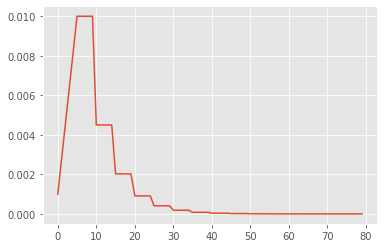

In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')


freeze_epo = 45
warmup_epo = 5
cosine_epo = 30
n_epochs = freeze_epo + warmup_epo + cosine_epo


model =  nn.Linear(100, 10)
optimizer = optim.Adam(model.parameters())
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_slr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.45)
# scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma= .5)
scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_slr)

tmp = []
for epoch in range(1, n_epochs+1):
  scheduler.step(epoch-1)
  tmp.append(optimizer.param_groups[0]["lr"])
#   print(scheduler.get_last_lr())


plt.plot(tmp)

Main indea is i choice schelder and
  try find bes param:
    - optimizer
    - lr

1. GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
2. i process

In [ ]:
"""      
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
https://stackoverflow.com/questions/64781266/optuna-pytorch-returned-value-from-the-objective-function-cannot-be-cast-to-flo

https://optuna.readthedocs.io/en/stable/tutorial/002_configurations.html#sphx-glr-tutorial-002-configurations-py
"""
def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('LR', 1e-4, 1e-2),
        'momentum' : trial.suggest_uniform('momentum', 0.8, 0.9),
        'optimizer': trial.suggest_categorical('optimizer',['Adam', 'SGD']), 
        'warm' : trial.suggest_int('warm', 1, 10), # how epoch up lr
        'multiplier': trial.suggest_int('multiplier', 1, 10),
        'l2': trial.suggest_loguniform('l2', 1.0e-5, 1.0e-4),
#         'step':trial.suggest_int('step', 2, 5),
#         'gamma':trial.suggest_float('gamma', 0.45, 1, step = 0.05)
        
      }
    
    freeze = 0
    cosine_epo =  30 - (freeze + param['warm'])  
    n_epoch = freeze + param['warm'] + cosine_epo  
    print(n_epoch, 'epoch')
    param['cosine'] = cosine_epo
    param['n_epoch'] = n_epoch
    tmp, tmp_loss, tmp_cor = [], [], []
    


    trial = hex(random.getrandbits(32)) 
    break_param = False
    for i in [1, 2, 4]:
        fold = i 
        transform_tr = None
        model = EffB3()  
        auc_max, loss, correct = showtime(model, fold, data, tr_idx, vl_idx, transform_tr, param, trial, scaler)
        tmp.append(auc_max)
        tmp_loss.append(loss)
        tmp_cor.append(correct)
        if np.max(tmp_cor) <= 190:
            print('Break....')
            break_param = True
            break
            
        
    print(tmp)
    print(tmp_loss)
    print(tmp_cor)
    print(f'Model trial: {trial}')
    """
    out see:
        Mon_Feb_15_16:42:28_2021,Fold:1,Epoch:29,lr:0.0000104,Auc_val:0.91488,Auc_train:0.00000,LRAPS:0.66527,lwlrap:0.00000,train_loss:0.33324,val_loss:0.72857
        [0.6739151142517208]
        [0.72041756]
        [128]
        Model trial: 0x424e617b    
    """
    
    if break_param:
        return 0
    return np.mean(tmp)

set_seed(SEED)
scaler = amp.GradScaler()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 40)
print(f'best trial : {study.best_trial}')
print(study.best_trial.params)